[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/StatMixedML/XGBoostLSS/blob/master/examples/ZAGA_simulation_example.ipynb)

# Imports

In [13]:
from xgboostlss.model import *
from xgboostlss.distributions.ZAGamma import *

from sklearn.model_selection import train_test_split 
import pandas as pd
import multiprocessing
import plotnine
from plotnine import *
plotnine.options.figure_size = (18, 9)
n_cpu = multiprocessing.cpu_count()

# Data

In [2]:
# The simulation example closely follows https://towardsdatascience.com/zero-inflated-regression-c7dfc656d8af
np.random.seed(123)
n_samples = 1000

data = pd.DataFrame({"age": np.random.randint(1, 100, size=n_samples)})
data["income"] = np.where((data.age > 17) & (data.age < 70), 1500*data.age + 5000 + 10000*np.random.randn(n_samples), 0) / 1000

y = data["income"].values.reshape(-1,1) 
X = data.drop(columns="income")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

dtrain = xgb.DMatrix(X_train, label=y_train, nthread=n_cpu)
dtest = xgb.DMatrix(X_test, nthread=n_cpu)

# Distribution Selection

In [3]:
# Specifies Zero-Adjusted Gamma distribution. See ?ZAGA for an overview.
xgblss = XGBoostLSS(
    ZAGamma(stabilization="None",        # Options are "None", "MAD", "L2".
            response_fn="exp",           # Function to transform the concentration and rate parameters, e.g., "exp" or "softplus".
            loss_fn="nll"                # Loss function. Options are "nll" (negative log-likelihood) or "crps"(continuous ranked probability score).)      
           )           
)

# Hyper-Parameter Optimization

In [4]:
# Any XGBoost hyperparameter can be tuned, where the structure of the parameter dictionary needs to be as follows:

    # Float/Int sample_type
        # {"param_name": ["sample_type", low, high, log]}
            # sample_type: str, Type of sampling, e.g., "float" or "int"
            # low: int, Lower endpoint of the range of suggested values
            # high: int, Upper endpoint of the range of suggested values
            # log: bool, Flag to sample the value from the log domain or not
        # Example: {"eta": "float", low=1e-5, high=1, log=True]}

    # Categorical sample_type
        # {"param_name": ["sample_type", ["choice1", "choice2", "choice3", "..."]]}
            # sample_type: str, Type of sampling, either "categorical"
            # choice1, choice2, choice3, ...: str, Possible choices for the parameter
        # Example: {"booster": ["categorical", ["gbtree", "dart"]]}

    # For parameters without tunable choice (this is needed if tree_method = "gpu_hist" and gpu_id needs to be specified)
        # {"param_name": ["none", [value]]},
            # param_name: str, Name of the parameter
            # value: int, Value of the parameter
        # Example: {"gpu_id": ["none", [0]]}

# Depending on which parameters are optimized, it might happen that some of them are not used, e.g., when {"booster":  ["categorical", ["gbtree", "gblinear"]]} and {"max_depth": ["int", 1, 10, False]} are
# specified, max_depth is not used when gblinear is sampled, since it has no such argument.

param_dict = {
    "eta":              ["float", {"low": 1e-5,   "high": 1,     "log": True}],
    "max_depth":        ["int",   {"low": 1,      "high": 10,    "log": False}],
    "gamma":            ["float", {"low": 1e-8,   "high": 40,    "log": True}],
    "subsample":        ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "colsample_bytree": ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "booster":          ["categorical", ["gbtree"]],
    # "tree_method":    ["categorical", ["auto", "approx", "hist", "gpu_hist"]],
    # "gpu_id":         ["none", [0]]
}

np.random.seed(123)
opt_param = xgblss.hyper_opt(param_dict,
                             dtrain,
                             num_boost_round=100,        # Number of boosting iterations.
                             nfold=5,                    # Number of cv-folds.
                             early_stopping_rounds=20,   # Number of early-stopping rounds
                             max_minutes=5,              # Time budget in minutes, i.e., stop study after the given number of minutes.
                             n_trials=10,                # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             silence=False,              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.
                             seed=123,                   # Seed used to generate cv-folds.
                             hp_seed=None                # Seed for random number generator used in the Bayesian hyperparameter search.
                            )

[I 2023-06-07 15:44:59,048] A new study created in memory with name: XGBoostLSS Hyper-Parameter Optimization
C:\Users\maerzale\.virtualenvs\XGBoostLSS-vIPRRz-M\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-06-07 15:45:04,584] Trial 0 finished with value: 449.300012 and parameters: {'eta': 0.0024660538025639465, 'max_depth': 8, 'gamma': 0.4713728278932427, 'subsample': 0.8714748051337524, 'colsample_bytree': 0.8049270099551873, 'booster': 'gbtree'}. Best is trial 0 with value: 449.300012.
[I 2023-06-07 15:45:09,822] Trial 1 finished with value: 503.47346200000004 and parameters: {'eta': 1.7409484431876265e-05, 'max_depth': 9, 'gamma': 0.10924562003239337, 'subsample': 0.2948710010058804, 'colsample_bytree': 0.4362614311903179, 'booster': 'gbtree'}. Best is trial 0 with value: 449.300012.
[I 2023-06-07 15:45:15,035] Trial 2 finished with value: 400.5749144 and parameters: {'eta': 0.007815023140893513, 'max_depth': 5, 'gamma': 0.007427003118265514, 'subsample': 0.7379644029327881, 'colsample_bytree': 0.9090716858951575, 'booster': 'gbtree'}. Best is trial 2 with value: 400.5749144.
[I 2023-06-07 15:45:20,592] Trial 3 finished with value: 501.5131652 and parameters: {'eta': 8.4303319

# Model Training

In [5]:
np.random.seed(123)

opt_params = opt_param.copy()
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Train Model with optimized hyperparameters
xgblss.train(opt_params,
             dtrain,
             num_boost_round=n_rounds
             )

# Prediction

In [6]:
# Set seed for reproducibility
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples = 1000
# Quantiles to calculate from predicted distribution
quant_sel = [0.05, 0.95] 

# Sample from predicted distribution
pred_samples = xgblss.predict(dtest,
                              pred_type="samples",
                              n_samples=n_samples,
                              seed=123)

# Calculate quantiles from predicted distribution
pred_quantiles = xgblss.predict(dtest,
                                pred_type="quantiles",
                                n_samples=n_samples,
                                quantiles=quant_sel)

# Returns predicted distributional parameters
pred_params = xgblss.predict(dtest,
                             pred_type="parameters")

In [7]:
pred_samples.head()

,y_sample0,y_sample1,y_sample2,y_sample3,y_sample4,y_sample5,y_sample6,y_sample7,y_sample8,y_sample9,...,y_sample990,y_sample991,y_sample992,y_sample993,y_sample994,y_sample995,y_sample996,y_sample997,y_sample998,y_sample999
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,60.663177,92.852440,57.069717,94.913544,156.625244,63.678719,69.863762,87.136543,108.545845,103.195251,...,92.850540,139.816757,96.714554,98.747704,104.813087,79.183533,71.594498,81.888184,128.041245,123.024628
2,40.451191,42.776321,24.952322,44.961067,33.017120,25.706108,46.723469,38.694794,43.540127,35.326035,...,29.746214,57.809830,29.703970,27.924829,40.267887,33.654690,32.927895,41.236584,38.887817,47.934742
3,32.663574,55.628910,54.732143,66.022530,119.770500,88.647331,40.399094,42.834343,60.017887,19.661150,...,39.326065,51.215214,51.643375,76.846481,47.634010,84.162819,58.548092,50.958031,69.514282,69.639519
4,0.000000,0.000000,0.000000,0.000000,0.000000,39.099194,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [8]:
pred_quantiles.head()

,quant_0.05,quant_0.95
0,0.000000,0.000000
1,52.842862,138.733070
2,20.807283,53.072018
3,31.337506,84.730654
4,0.000000,0.000000


In [9]:
pred_params.head()

,concentration,rate,gate
0,13.935776,0.129919,0.995262
1,13.131942,0.145704,0.006040
2,11.548386,0.319526,0.007780
3,11.315641,0.198417,0.002843
4,10.247254,0.403604,0.990306


# SHAP Interpretability

C:\Users\maerzale\.virtualenvs\XGBoostLSS-vIPRRz-M\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
C:\Users\maerzale\.virtualenvs\XGBoostLSS-vIPRRz-M\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide


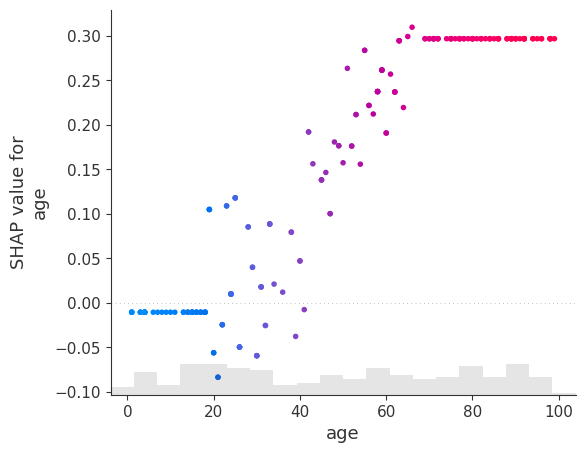

In [10]:
# Partial Dependence Plot of concentration parameter
xgblss.plot(X_test,
            parameter="concentration",
            feature="age",
            plot_type="Partial_Dependence")

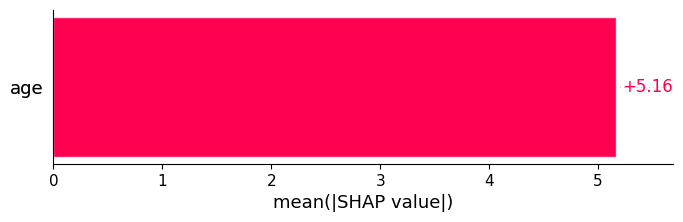

In [11]:
# Feature Importance of gate parameter
xgblss.plot(X_test,
            parameter="gate",
            plot_type="Feature_Importance")

# Density Plots of Actual and Predicted Samples

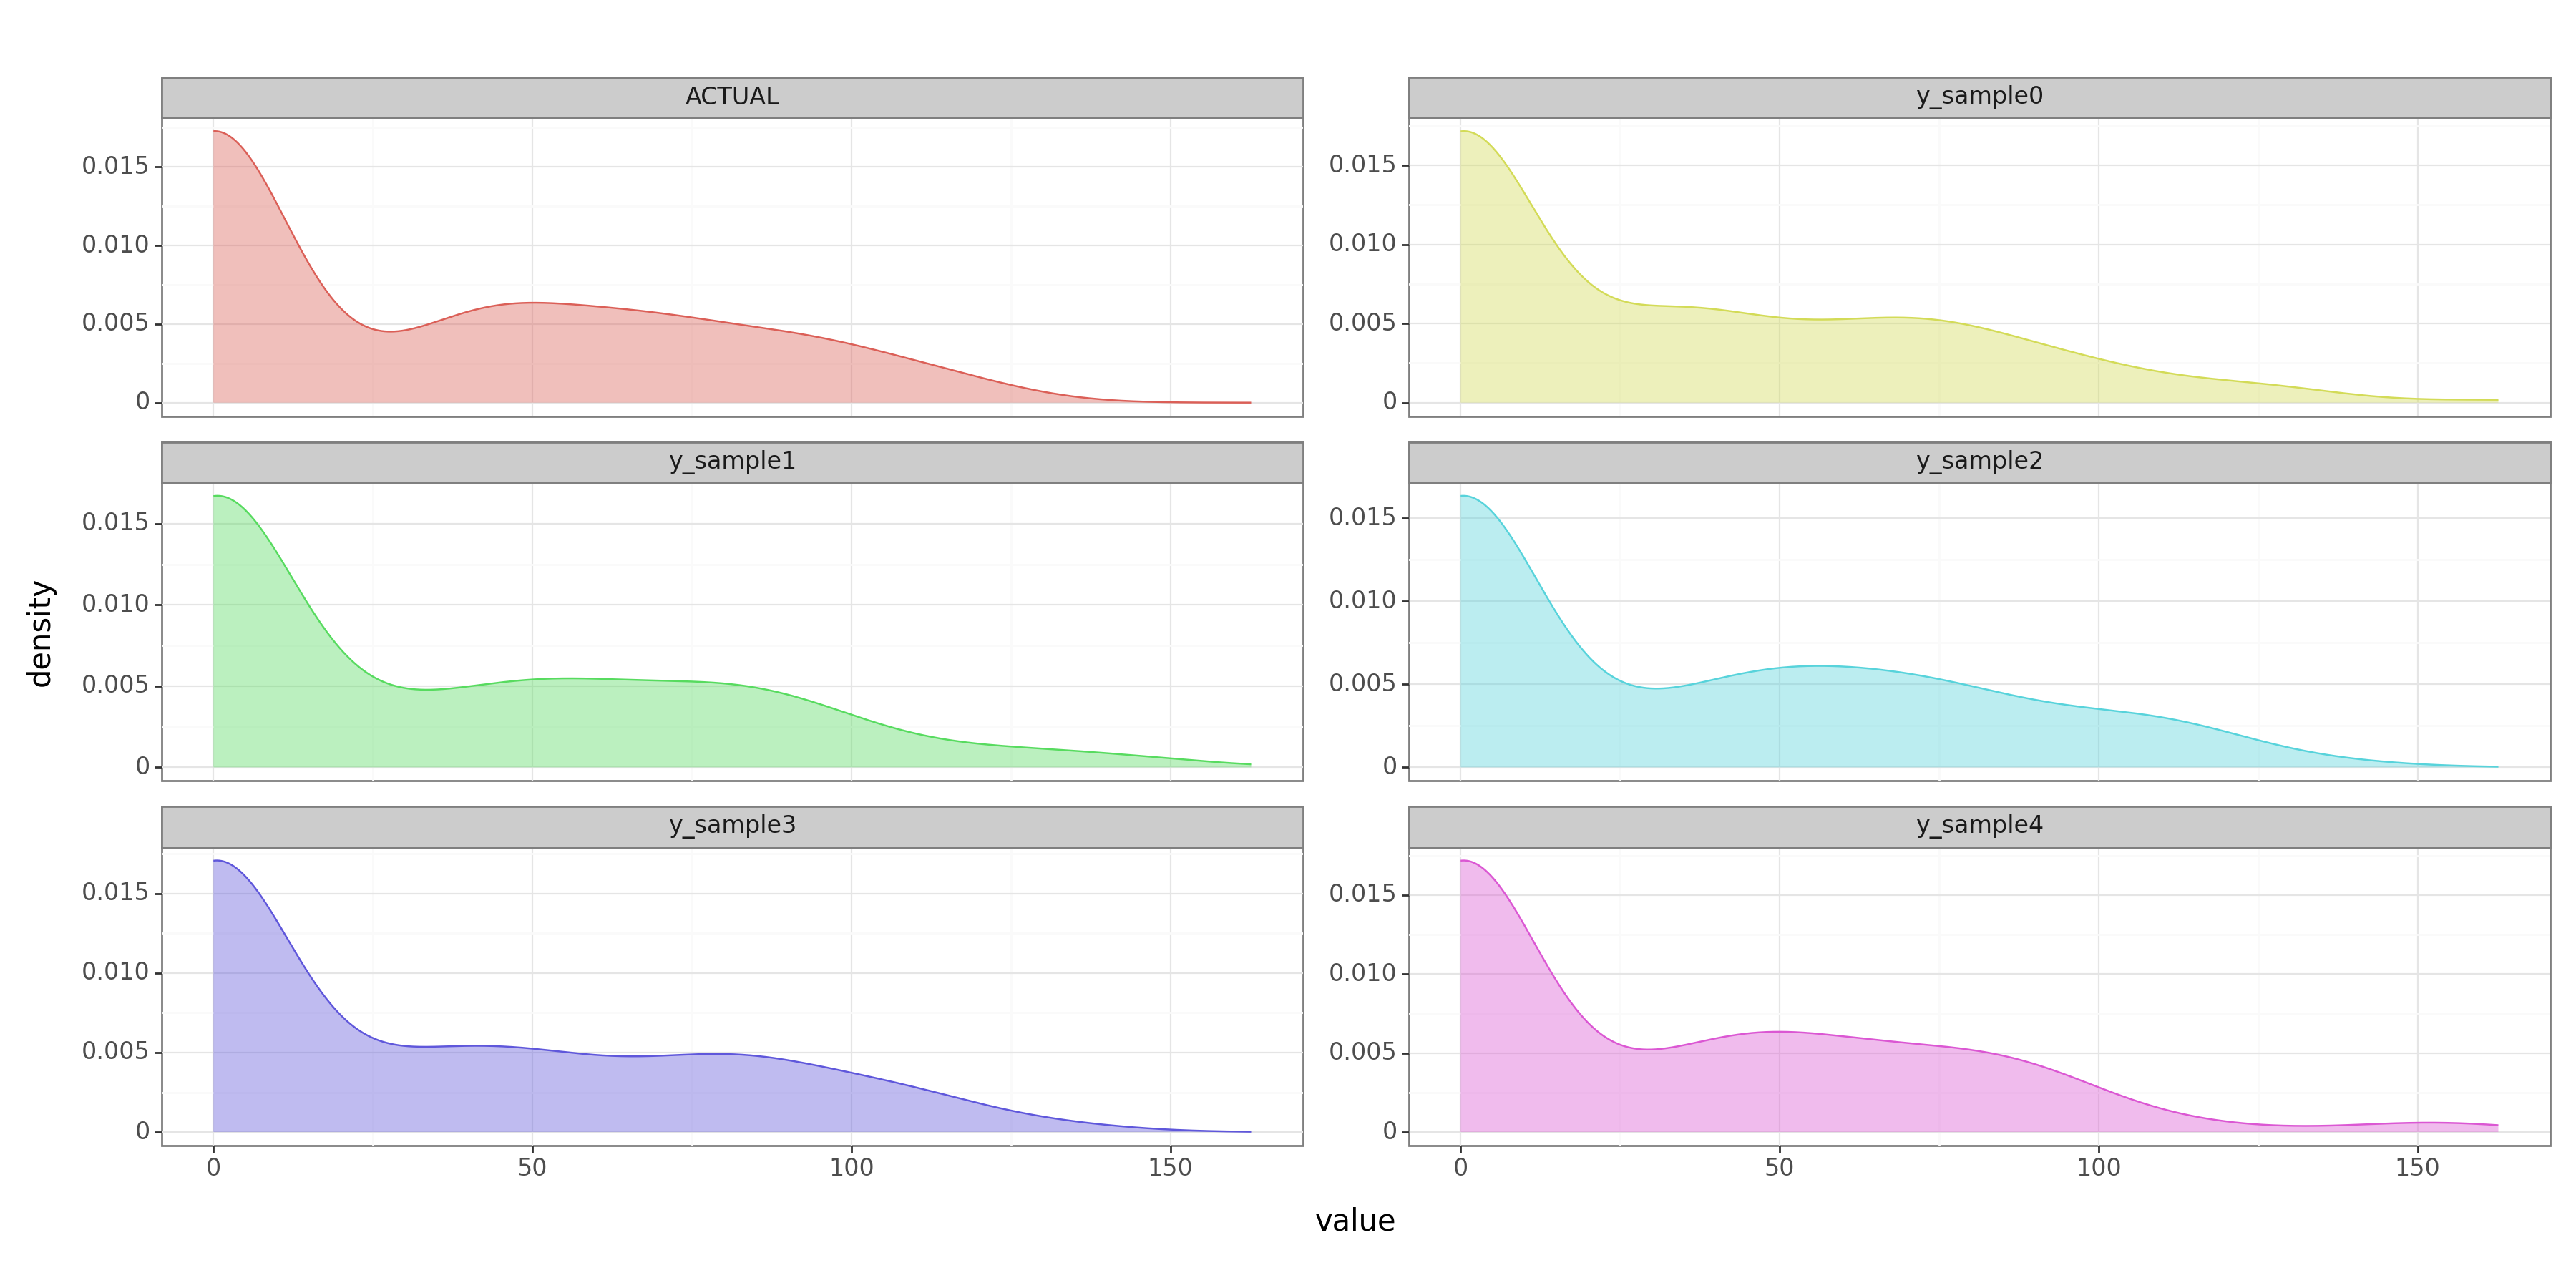

<Figure Size: (1800 x 900)>

In [12]:
pred_df = pd.melt(pred_samples.iloc[:,0:5])
actual_df = pd.DataFrame.from_dict({"variable": "ACTUAL", "value": y_test.reshape(-1,)})
plot_df = pd.concat([pred_df, actual_df])

(
    ggplot(plot_df, 
           aes(x="value",
               color="variable",
               fill="variable")) +  
    geom_density(alpha=0.4) + 
    facet_wrap("variable",
              scales="free_y",
              ncol=2) + 
    theme_bw(base_size=15) + 
    theme(legend_position="none")
)